In [33]:
import keras
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
from keras.models import Model
from keras.layers import Dense, Dropout, Flatten, Input, Lambda
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from keras.losses import mse, binary_crossentropy
from keras.callbacks import ModelCheckpoint
from keras.callbacks import TensorBoard

In [3]:
batch_size = 128
n_classes = 10
n_epochs = 15

im_row, im_col = 28, 28

In [38]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

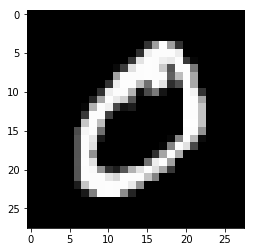

In [39]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.imshow(x_train[1], cmap='gray')
plt.show()

In [40]:
if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], im_row * im_col)
    x_test = x_test.reshape(x_test.shape[0],im_row * im_col)
    input_shape = (im_row * im_col)
else:
    x_train = x_train.reshape(x_train.shape[0], im_row * im_col)
    x_test = x_test.reshape(x_test.shape[0], im_row * im_col)
    input_shape = (im_row * im_col)

In [41]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

y_train = keras.utils.to_categorical(y_train, n_classes)
y_test = keras.utils.to_categorical(y_test, n_classes)

In [42]:
print("x_train: {}\nx_test: {}\ninput_shape: {}\n \
# of training samples: {}\n# of testing samples: {}".format( 
x_train.shape, x_test.shape, input_shape, x_train.shape[0], x_test.shape[0]))

x_train: (60000, 784)
x_test: (10000, 784)
input_shape: 784
 # of training samples: 60000
# of testing samples: 10000


In [43]:
def sampling(args):
    """Reparameterization trick by sampling from an isotropic unit Gaussian.
    # Arguments
        args (tensor): mean and log of variance of Q(z|X)
    # Returns
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [68]:
logfilename = "variationalautoencoder"


original_dim  = x_train.shape[1]

print(original_dim)

input_shape = (original_dim,)
intermediate_dim = 256
batch_size = 64
latent_dim = 2
epochs = 60

# VAE model = encoder + decoder
# build encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = Dense(intermediate_dim, activation='relu')(inputs)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()

# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = Dense(original_dim, activation='sigmoid')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae_mlp')


# VAE loss = mse_loss or xent_loss + kl_loss
reconstruction_loss = mse(inputs, outputs)

reconstruction_loss *= original_dim
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)

784
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
encoder_input (InputLayer)       (None, 784)           0                                            
____________________________________________________________________________________________________
dense_17 (Dense)                 (None, 256)           200960      encoder_input[0][0]              
____________________________________________________________________________________________________
z_mean (Dense)                   (None, 2)             514         dense_17[0][0]                   
____________________________________________________________________________________________________
z_log_var (Dense)                (None, 2)             514         dense_17[0][0]                   
_______________________________________________________________________________________

In [69]:


vae.compile(optimizer='adam', 
                    loss='mean_squared_error',
                    metrics=['accuracy'])
vae.summary()



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 784)               0         
_________________________________________________________________
encoder (Model)              [(None, 2), (None, 2), (N 201988    
_________________________________________________________________
decoder (Model)              (None, 784)               202256    
Total params: 404,244
Trainable params: 404,244
Non-trainable params: 0
_________________________________________________________________


In [70]:
history = vae.fit(x_train, x_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    shuffle=True,
                    validation_data=(x_test, x_test),
                    callbacks=[TensorBoard(log_dir='../logs/{0}'.format(logfilename))])

Train on 60000 samples, validate on 10000 samples
Epoch 1/60
60000/60000 [==============================] - 9s - loss: 50.2978 - acc: 0.0136 - val_loss: 43.7600 - val_acc: 0.0153
Epoch 2/60
60000/60000 [==============================] - 9s - loss: 43.3880 - acc: 0.0148 - val_loss: 42.5286 - val_acc: 0.0154
Epoch 3/60
60000/60000 [==============================] - 10s - loss: 42.3851 - acc: 0.0166 - val_loss: 41.7288 - val_acc: 0.0144
Epoch 4/60
60000/60000 [==============================] - 9s - loss: 41.6682 - acc: 0.0165 - val_loss: 41.2287 - val_acc: 0.0111
Epoch 5/60
60000/60000 [==============================] - 10s - loss: 41.1560 - acc: 0.0145 - val_loss: 40.7961 - val_acc: 0.0132
Epoch 6/60
60000/60000 [==============================] - 9s - loss: 40.7690 - acc: 0.0136 - val_loss: 40.5230 - val_acc: 0.0130
Epoch 7/60
60000/60000 [==============================] - 9s - loss: 40.4291 - acc: 0.0134 - val_loss: 40.2279 - val_acc: 0.0127
Epoch 8/60
60000/60000 [=====================

In [71]:
preds = vae.predict(x_test)

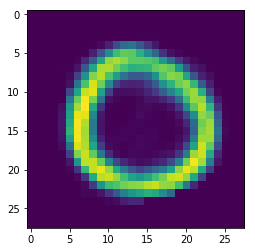

In [84]:
plt.imshow(preds[69].reshape(28, 28))

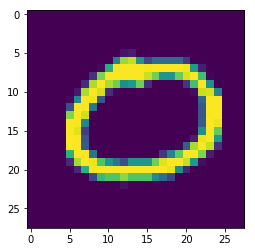

In [85]:
plt.imshow(x_test[69].reshape(28, 28))